### Required Modules

In [ ]:
import numpy as np 
import pandas as pd
import h5py as h5
import seaborn as sns
import tensorflow as tf
import sys

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from scripts.utils import train_keys

In [ ]:
import pickle
import matplotlib.pyplot as plt
import seaborn as sns

### Load Data 

In [ ]:
train_data = pd.read_pickle("/share/rcifdata/jbarr/UKAEAGroupProject/data/train_data_clipped.pkl")

X_train, Y_train = train_data.iloc[:,:15].to_numpy(), train_data.iloc[:,-1].to_numpy()

validation_data = pd.read_pickle("/share/rcifdata/jbarr/UKAEAGroupProject/data/valid_data_clipped.pkl")

X_val, Y_val = validation_data.iloc[:,:15].to_numpy(), validation_data.iloc[:,-1].to_numpy()

In [4]:
print(X_train.shape)

(26715960, 15)


In [ ]:
# corr = X_train.corr()

#plt.figure(figsize = (12,8))
#sns.heatmap(corr, xticklabels = corr.columns, yticklabels = corr.columns, linewidths = .5, cmap = "hot")

In [ ]:
# standard scaler
scaler = StandardScaler()
scaler.fit(X_train)
x_train = scaler.transform(X_train)
x_val = scaler.transform (X_val)

###  Best Neural Network Classifier From Initial Grid Search

**Initial Grid Search Parameters**

Number of nodes: [5,10, 20, 30]

Number of layers: [2,3,4]

In [6]:
file_path = '/share/rcifdata/jbarr/UKAEAGroupProject/grid_search/'
trainings = []
for i in range(336):
    trial_dict = pickle.load(open(file_path+"trial_"+str(i)+".pkl", 'rb'))
    trainings.append(trial_dict)

In [7]:
### calculate the number of parameters
def model_params(nodes, n_inputs=15):
    nodes.append(1)
    params = 0
    
    # bottle neck, 0 if model doesn't include a bottle neck and 1 if the model does include one.
    bottle_in = 0
    bottle_hidden = 0
    
    # parameters from models
    for i in range(len(nodes)):
        if i == 0:
            if nodes[i] < n_inputs: bottle_in = 1
            params += n_inputs * nodes[i]
        else:
            params += nodes[i-1]* nodes[i]
            
            if nodes[i-1] < nodes[i]: bottle_hidden = 1
    
    # parameters from biases
    for i in nodes: 
        params += i
    return params, bottle_in, bottle_hidden

In [8]:
assert model_params([2,2])[0] == 41

In [9]:
# Find the best architecture
best_trial = None 
best_val_acc = - sys.float_info.max
val_accs = []
n_params = []
bottle_in = []
bottle_hid = []

for trial in trainings:
    val_acc = trial["perfomance"][1]
    
    val_accs.append(val_acc)
    
    n_param, bot_in, bot_hid  = model_params(list(trial['nodes']))
    
    n_params.append(n_param)
    
    bottle_in.append(bot_in)
    bottle_hid.append(bot_hid)
    
    
    
    if val_acc > best_val_acc: 
        best_val_acc = val_acc
        best_trial = trial
        
n_params = np.array(n_params)
bottle_in = np.array(bottle_in)
bottle_hid= np.array(bottle_hid)
val_accs = np.array(val_accs)


In [10]:
print("Best Model\n")
print("Network:",best_trial["nodes"],"\n" )
print("Validation accuracy:", best_trial['perfomance'][1])

Best Model

Network: [30 30 30 30] 

Validation accuracy: 0.8433062434196472


Text(0, 0.5, 'Accuracy')

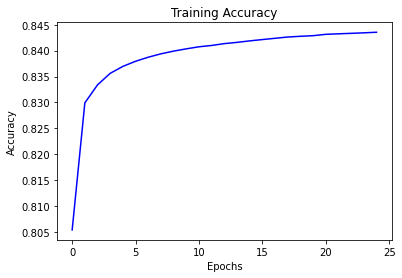

In [11]:
plt.figure()
plt.plot(best_trial["history"]["acc"],color = 'blue')
plt.title("Training Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")

Text(0, 0.5, 'MSE')

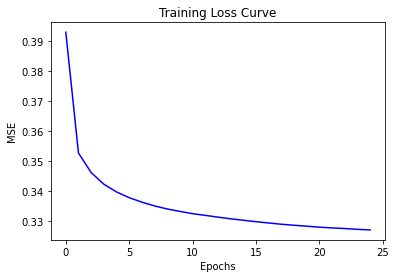

In [12]:
plt.figure()
plt.plot(best_trial["history"]["loss"], color = 'blue')
plt.title("Training Loss Curve")
plt.xlabel("Epochs")
plt.ylabel("MSE")

Text(0, 0.5, 'Frequency')

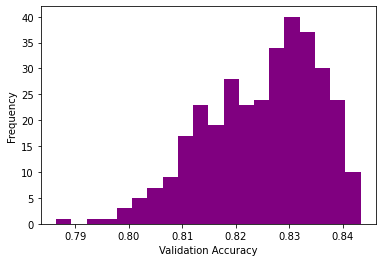

In [13]:
plt.figure()
plt.hist(val_accs, bins = 20, color = 'purple');
plt.xlabel("Validation Accuracy")
plt.ylabel("Frequency")

<<<<<<< local


<<<<<<< local <modified: text/plain>


>>>>>>> remote <removed>


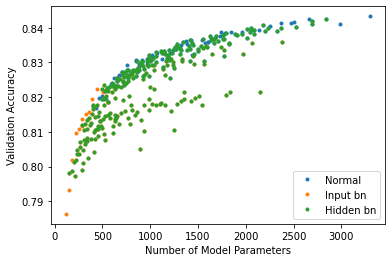

>>>>>>> remote


In [14]:
plt.figure()
plt.plot(n_params[np.where(bottle_in == 0)], val_accs[np.where(bottle_in == 0)], '.', label = 'Normal')
plt.plot(n_params[np.where(bottle_in == 1)], val_accs[np.where(bottle_in == 1)], '.', label = 'Input bn')
plt.plot(n_params[np.where(bottle_hid == 1)], val_accs[np.where(bottle_hid == 1)], '.', label = 'Hidden bn')
plt.xlabel("Number of Model Parameters")
plt.ylabel("Validation Accuracy")
plt.legend()

### Grid Search Conclusion

Looking at the plot above we can see that increasing the number of model parameters in general leads to an increase in the models validation accuracy, the graph looks as though it will plateau, but it also suggestes we haven't hit the peak, a further grid search of models with a higher number of parameters should be conducted.

### Final classifier

In [15]:
def nn_classifier():
    model = tf.keras.Sequential([
    tf.keras.layers.Dense(30, activation = 'tanh'),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Dense(30, activation = 'tanh'),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Dense(30, activation = 'tanh'),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Dense(30, activation = 'tanh'),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Dense(1, activation = 'sigmoid')   
    ])
    return model

In [16]:
model = nn_classifier()

<<<<<<< local


<<<<<<< local <modified: >


2022-03-10 18:35:10.917435: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-03-10 18:35:10.918176: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-03-10 18:35:10.918331: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


>>>>>>> remote <removed>


2022-03-10 15:43:35.993493: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-03-10 15:43:35.994074: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-03-10 15:43:35.994205: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


>>>>>>> remote


In [17]:
model.compile(optimizer = 'adam', loss ='binary_crossentropy', metrics = 'acc')
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_acc', patience=5)

In [18]:
history = model.fit(x_train, Y_train, validation_data = (x_val, Y_val), batch_size = 4096, epochs =50, callbacks=[stop_early])

<<<<<<< local


<<<<<<< local <modified: >


2022-03-10 18:35:33.798586: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2022-03-10 18:35:33.813404: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 2200000000 Hz


>>>>>>> remote <removed>


Epoch 1/50
6523/6523 [==============================] - 347s 51ms/step - loss: 0.4837 - acc: 0.7460 - val_loss: 0.3819 - val_acc: 0.8157
Epoch 2/50
6523/6523 [==============================] - 275s 42ms/step - loss: 0.4049 - acc: 0.8011 - val_loss: 0.3720 - val_acc: 0.8217
Epoch 3/50
6523/6523 [==============================] - 252s 39ms/step - loss: 0.3969 - acc: 0.8060 - val_loss: 0.3682 - val_acc: 0.8240
Epoch 4/50
3928/6523 [=================>............] - ETA: 1:42 - loss: 0.3938 - acc: 0.8080

KeyboardInterrupt: 

2022-03-10 15:43:36.460777: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2022-03-10 15:43:36.461623: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 2200000000 Hz


Epoch 1/50
816/816 [==============================] - 8s 9ms/step - loss: 0.5486 - acc: 0.6926 - val_loss: 0.4379 - val_acc: 0.7768
Epoch 2/50
816/816 [==============================] - 6s 8ms/step - loss: 0.4262 - acc: 0.7852 - val_loss: 0.3944 - val_acc: 0.8063
Epoch 3/50
816/816 [==============================] - 6s 8ms/step - loss: 0.3904 - acc: 0.8090 - val_loss: 0.3792 - val_acc: 0.8159
Epoch 4/50
816/816 [==============================] - 6s 8ms/step - loss: 0.3771 - acc: 0.8173 - val_loss: 0.3701 - val_acc: 0.8215
Epoch 5/50
816/816 [==============================] - 6s 8ms/step - loss: 0.3694 - acc: 0.8217 - val_loss: 0.3649 - val_acc: 0.8241
Epoch 6/50
816/816 [==============================] - 6s 7ms/step - loss: 0.3641 - acc: 0.8246 - val_loss: 0.3606 - val_acc: 0.8265
Epoch 7/50
816/816 [==============================] - 6s 7ms/step - loss: 0.3611 - acc: 0.8262 - val_loss: 0.3596 - val_acc: 0.8267
Epoch 8/50
816/816 [==============================] - 6s 8ms/step - loss: 0.

>>>>>>> remote


In [19]:
# !mkdir -p saved_model
# model.save('saved_model/classifier_model')

2022-03-10 15:48:42.096748: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: saved_model/classifier_model/assets


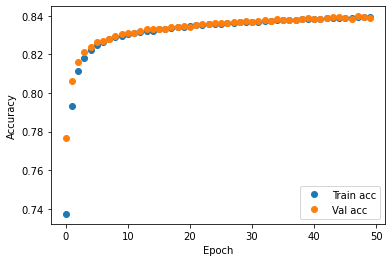

In [20]:
plt.figure()
plt.plot(history.history['acc'], 'o', label = 'Train acc')
plt.plot(history.history['val_acc'], 'o', label = 'Val acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

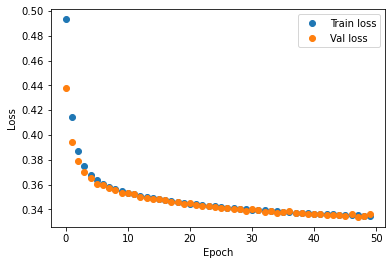

In [21]:
plt.figure()
plt.plot(history.history['loss'], 'o', label = 'Train loss')
plt.plot(history.history['val_loss'], 'o', label = 'Val loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

### Evaluate Model on Test Set

In [22]:
from sklearn.metrics import roc_curve

In [ ]:
!ls /share/rcifdata/jbarr/UKAEAGroupProject/data/

In [23]:
test_data = pd.read_pickle("/share/rcifdata/jbarr/UKAEAGroupProject/data/test_data_clipped.pkl")

X_test, Y_test = test_data.iloc[:,:15].to_numpy(), test_data.iloc[:,-1].to_numpy()

In [24]:
x_test = scaler.transform(X_test)

In [25]:
predictions = model.predict(x_test)

fpr, tpr, thresholds = roc_curve(Y_test, predictions)

In [26]:
from sklearn.metrics import roc_auc_score
auc = roc_auc_score(Y_test, predictions)

Text(0.8, 0.2, 'auc =  0.92')

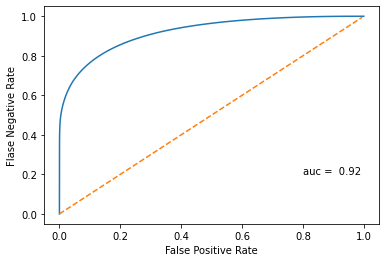

In [27]:
plt.figure()
plt.plot(fpr, tpr)
random_class = np.arange(0,1,0.005)
plt.plot(random_class, random_class, '--')
plt.xlabel('False Positive Rate')
plt.ylabel('Flase Negative Rate')
plt.text(0.8, 0.2, f'auc = {auc: .2f}', fontsize=10)

In [28]:
test_pred = np.where(predictions < 0.5, predictions, 1)
test_pred = np.where(predictions >= 0.5, test_pred, 0)

In [29]:
n_positive = np.where(Y_test ==0)[0].shape[0]
n_negative = np.where(Y_test ==1)[0].shape[0]
div_arr = np.array([[n_positive, n_negative]]).T

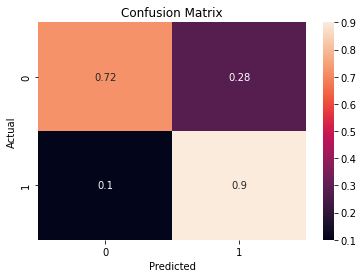

In [30]:
con_mat = confusion_matrix(Y_test, test_pred, labels =[0,1])/div_arr
sns.heatmap(con_mat, annot=True).set(title='Confusion Matrix', xlabel='Predicted', ylabel='Actual');

### Distributions from classifier

In [31]:
preds = np.round(predictions).flatten()

In [32]:
no_output = x_test[np.where(preds == 0)]
yes_output = x_test[np.where(preds == 1)] 
assert no_output.shape[0] + yes_output.shape[0] == x_test.shape[0]

In [33]:
columns = list(train_data.iloc[:,:-1].columns)
print(columns)

['ane', 'ate', 'autor', 'machtor', 'x', 'zeff', 'gammae', 'q', 'smag', 'alpha', 'ani1', 'ati0', 'normni1', 'ti_te0', 'lognustar']


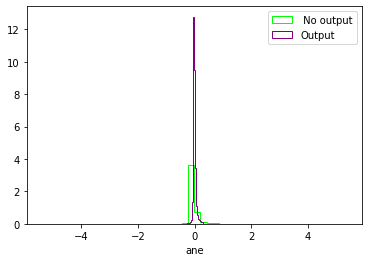

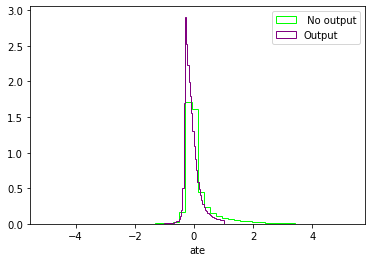

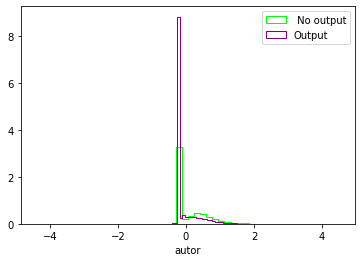

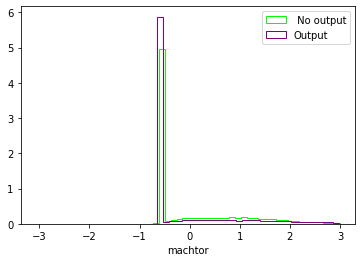

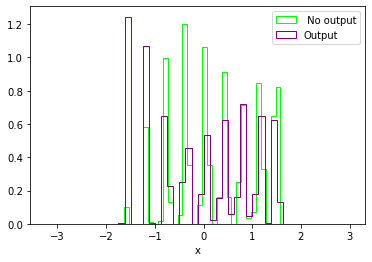

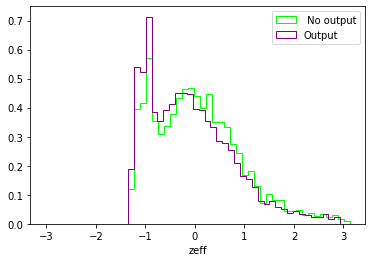

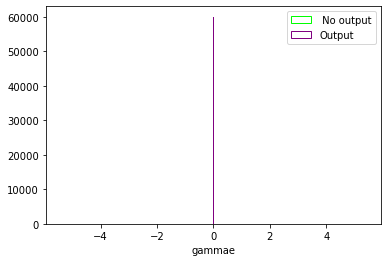

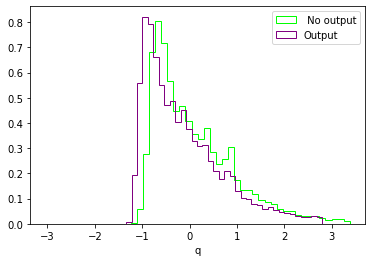

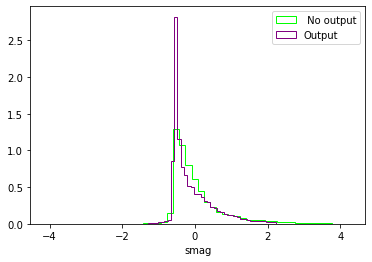

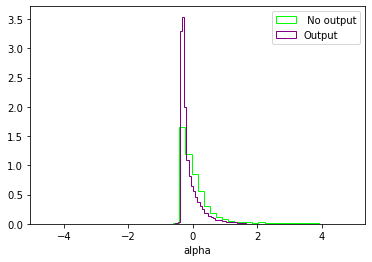

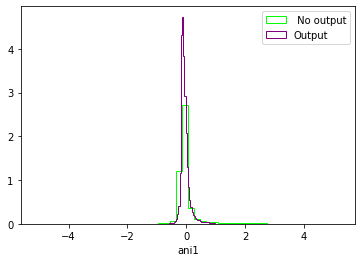

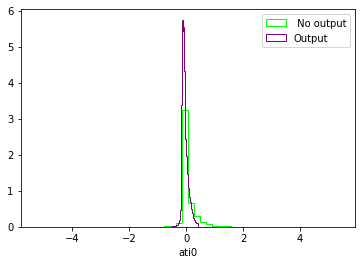

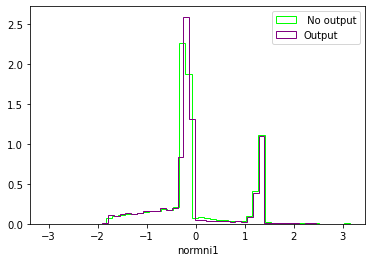

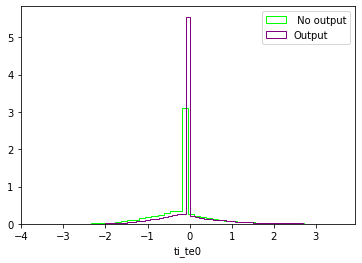

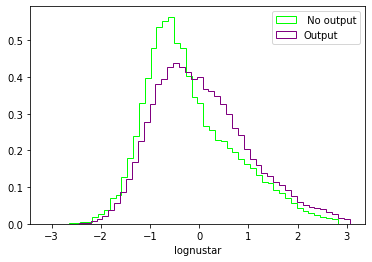

In [34]:
for i, column in enumerate(columns):
    # find the mean and std 
    mean_no, mean_yes = np.mean(no_output[:,i]), np.mean(yes_output[:,i])
    std_no, std_yes = np.std(no_output[:,i]), np.std(yes_output[:,i])
    
    no_lower, no_upper = (mean_no - 3*std_no), (mean_no + 3*std_no)
    yes_lower, yes_upper = (mean_yes - 3*std_yes), (mean_yes + 3*std_yes)
    
    plt.figure()
    plt.hist(no_output[:,i], histtype = 'step', color = 'lime',
             label =" No output", density = True, bins =50, range = (no_lower, no_upper));
    
    plt.hist(yes_output[:,i], histtype = 'step', color = 'purple',
             label = "Output", density = True, bins = 50, range = (yes_lower,yes_upper ));
    plt.legend()
    plt.xlabel(column)

# Train model with varying number of data points

In [35]:
def nn_classifier_big():
    model = tf.keras.Sequential([
        tf.keras.layers.Dense(256, activation = 'relu'),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(256, activation = 'relu'),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(256, activation = 'relu'),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(256,activation = 'relu'),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(256, activation = 'relu'),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(256, activation = 'relu'),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(128, activation = 'relu'),
        tf.keras.layers.Dropout(0.1),
        tf.keras.layers.Dense(1, activation = 'sigmoid')   
    ])
    return model

# def nn_classifier_big():
#     model = tf.keras.Sequential([
#     tf.keras.layers.Dense(30, activation = 'relu'),
#     tf.keras.layers.Dropout(0.1),
#     tf.keras.layers.Dense(30, activation = 'relu'),
#     tf.keras.layers.Dropout(0.1),
#     tf.keras.layers.Dense(30, activation = 'relu'),
#     tf.keras.layers.Dropout(0.1),
#     tf.keras.layers.Dense(1, activation = 'sigmoid')   
#     ])
#     return model

In [ ]:
<<<<<<< REMOTE CELL DELETED >>>>>>>
# def nn_classifier_big():
#     model = tf.keras.Sequential([
#     tf.keras.layers.Dense(64, activation = 'relu'),
#     tf.keras.layers.Dropout(0.1),
#     tf.keras.layers.Dense(64, activation = 'relu'),
#     tf.keras.layers.Dropout(0.1),
#     tf.keras.layers.Dense(64, activation = 'relu'),
#     tf.keras.layers.Dropout(0.1),
#     tf.keras.layers.Dense(64, activation = 'relu'),
#     tf.keras.layers.Dropout(0.1),
#     tf.keras.layers.Dense(64, activation = 'relu'),
#     tf.keras.layers.Dropout(0.1),
#     tf.keras.layers.Dense(1, activation = 'sigmoid')   
#     ])
#     return model
def nn_classifier_big():
    model = tf.keras.Sequential([
    tf.keras.layers.Dense(150, activation = 'relu'),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Dense(75, activation = 'relu'),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Dense(30, activation = 'relu'),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Dense(1, activation = 'sigmoid')   
    ])
    return model

In [ ]:
val_indices = np.random.choice(x_val.shape[0], size = 100_000, replace=False)
x_val_sample = x_val[val_indices]
y_val_sample = Y_val[val_indices]

In [ ]:
training_size = [1000, 2000, 5000,
                10_000, 12_500, 15_000, 20_000]#, 30_000, 50_000,
                 #100_000, 200_000, 500_000,
                 #1_000_000, x_train.shape[0]]
train_losses = []
val_losses = []

train_accuracies = []
val_accuracies = []

permuted_idx = np.random.permutation(x_train.shape[0])
permuted_x = x_train[permuted_idx]
permuted_y = Y_train[permuted_idx]

for size in training_size:

    x_sample = permuted_x[:size]
    y_sample = permuted_y[:size]
    
    batch_size = size if size <= 10_000 else 4096
    patience = 25 if size <= 10_000 else 5
    
    print(f"Training model with {size} training points:")
    model = nn_classifier_big()
    model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = 'acc')
    stop_early = tf.keras.callbacks.EarlyStopping(monitor = 'val_acc', patience = patience)
    history = model.fit(x_sample,
                        y_sample,
                        validation_data = (x_val_sample, y_val_sample),
                        batch_size = batch_size,
                        epochs = 100,
                        callbacks = [stop_early])

    train_losses.append(history.history['loss'])
    val_losses.append(history.history['val_loss'])
    train_accuracies.append(history.history['acc'])
    val_accuracies.append(history.history['val_acc'])
    
    print("\n \n")

Training model with 1000 training points:
Epoch 1/100
1/1 [==============================] - 3s 3s/step - loss: 0.6839 - acc: 0.6370 - val_loss: 0.6654 - val_acc: 0.6612
Epoch 2/100
1/1 [==============================] - 2s 2s/step - loss: 0.6661 - acc: 0.6490 - val_loss: 0.6505 - val_acc: 0.6612
Epoch 3/100
1/1 [==============================] - 2s 2s/step - loss: 0.6637 - acc: 0.6490 - val_loss: 0.6385 - val_acc: 0.6612
Epoch 4/100
1/1 [==============================] - 2s 2s/step - loss: 0.6561 - acc: 0.6490 - val_loss: 0.6283 - val_acc: 0.6612
Epoch 5/100
1/1 [==============================] - 2s 2s/step - loss: 0.6345 - acc: 0.6490 - val_loss: 0.6185 - val_acc: 0.6612
Epoch 6/100
1/1 [==============================] - 2s 2s/step - loss: 0.6272 - acc: 0.6490 - val_loss: 0.6086 - val_acc: 0.6612
Epoch 7/100
1/1 [==============================] - 1s 1s/step - loss: 0.6177 - acc: 0.6490 - val_loss: 0.5996 - val_acc: 0.6612
Epoch 8/100
1/1 [==============================] - 2s 2s/step 

1/1 [==============================] - 2s 2s/step - loss: 0.5249 - acc: 0.7230 - val_loss: 0.5479 - val_acc: 0.6961
Epoch 49/100
1/1 [==============================] - 2s 2s/step - loss: 0.5245 - acc: 0.7200 - val_loss: 0.5454 - val_acc: 0.6973
Epoch 50/100
1/1 [==============================] - 2s 2s/step - loss: 0.5191 - acc: 0.7280 - val_loss: 0.5432 - val_acc: 0.6976
Epoch 51/100
1/1 [==============================] - 2s 2s/step - loss: 0.5149 - acc: 0.7285 - val_loss: 0.5414 - val_acc: 0.6988
Epoch 52/100
1/1 [==============================] - 2s 2s/step - loss: 0.5111 - acc: 0.7365 - val_loss: 0.5404 - val_acc: 0.7006
Epoch 53/100
1/1 [==============================] - 2s 2s/step - loss: 0.5130 - acc: 0.7380 - val_loss: 0.5406 - val_acc: 0.7020
Epoch 54/100
1/1 [==============================] - 2s 2s/step - loss: 0.5097 - acc: 0.7365 - val_loss: 0.5404 - val_acc: 0.7030
Epoch 55/100
1/1 [==============================] - 2s 2s/step - loss: 0.5084 - acc: 0.7410 - val_loss: 0.5401

1/1 [==============================] - 2s 2s/step - loss: 0.4968 - acc: 0.7386 - val_loss: 0.5078 - val_acc: 0.7247
Epoch 75/100
1/1 [==============================] - 2s 2s/step - loss: 0.4973 - acc: 0.7310 - val_loss: 0.5073 - val_acc: 0.7247
Epoch 76/100
1/1 [==============================] - 2s 2s/step - loss: 0.4964 - acc: 0.7376 - val_loss: 0.5073 - val_acc: 0.7244
Epoch 77/100
1/1 [==============================] - 2s 2s/step - loss: 0.4945 - acc: 0.7356 - val_loss: 0.5067 - val_acc: 0.7253
Epoch 78/100
1/1 [==============================] - 2s 2s/step - loss: 0.4934 - acc: 0.7398 - val_loss: 0.5069 - val_acc: 0.7258
Epoch 79/100
1/1 [==============================] - 2s 2s/step - loss: 0.4966 - acc: 0.7352 - val_loss: 0.5061 - val_acc: 0.7259
Epoch 80/100
1/1 [==============================] - 2s 2s/step - loss: 0.4876 - acc: 0.7466 - val_loss: 0.5059 - val_acc: 0.7252
Epoch 81/100
1/1 [==============================] - 2s 2s/step - loss: 0.4894 - acc: 0.7402 - val_loss: 0.5062

1/1 [==============================] - 2s 2s/step - loss: 0.4760 - acc: 0.7520 - val_loss: 0.4842 - val_acc: 0.7440

 

Training model with 12500 training points:
Epoch 1/100
4/4 [==============================] - 4s 774ms/step - loss: 0.6808 - acc: 0.6230 - val_loss: 0.6348 - val_acc: 0.6612
Epoch 2/100
4/4 [==============================] - 2s 670ms/step - loss: 0.6446 - acc: 0.6575 - val_loss: 0.6023 - val_acc: 0.6612
Epoch 3/100
4/4 [==============================] - 2s 660ms/step - loss: 0.6111 - acc: 0.6548 - val_loss: 0.5892 - val_acc: 0.6623
Epoch 4/100
4/4 [==============================] - 2s 665ms/step - loss: 0.5964 - acc: 0.6570 - val_loss: 0.5796 - val_acc: 0.6657
Epoch 5/100
4/4 [==============================] - 2s 657ms/step - loss: 0.5845 - acc: 0.6611 - val_loss: 0.5756 - val_acc: 0.6666
Epoch 6/100
4/4 [==============================] - 2s 653ms/step - loss: 0.5786 - acc: 0.6621 - val_loss: 0.5714 - val_acc: 0.6670
Epoch 7/100
4/4 [==============================] - 

4/4 [==============================] - 4s 1s/step - loss: 0.3992 - acc: 0.8028 - val_loss: 0.4447 - val_acc: 0.7790
Epoch 91/100
4/4 [==============================] - 5s 1s/step - loss: 0.3989 - acc: 0.8019 - val_loss: 0.4433 - val_acc: 0.7793
Epoch 92/100
4/4 [==============================] - 4s 1s/step - loss: 0.3989 - acc: 0.8021 - val_loss: 0.4459 - val_acc: 0.7772
Epoch 93/100
4/4 [==============================] - 4s 1s/step - loss: 0.3932 - acc: 0.8105 - val_loss: 0.4440 - val_acc: 0.7792
Epoch 94/100
4/4 [==============================] - 4s 1s/step - loss: 0.3932 - acc: 0.8064 - val_loss: 0.4429 - val_acc: 0.7802
Epoch 95/100
4/4 [==============================] - 4s 1s/step - loss: 0.3923 - acc: 0.8091 - val_loss: 0.4407 - val_acc: 0.7791
Epoch 96/100
4/4 [==============================] - 4s 1s/step - loss: 0.3890 - acc: 0.8064 - val_loss: 0.4450 - val_acc: 0.7792
Epoch 97/100
4/4 [==============================] - 4s 1s/step - loss: 0.3880 - acc: 0.8122 - val_loss: 0.4446

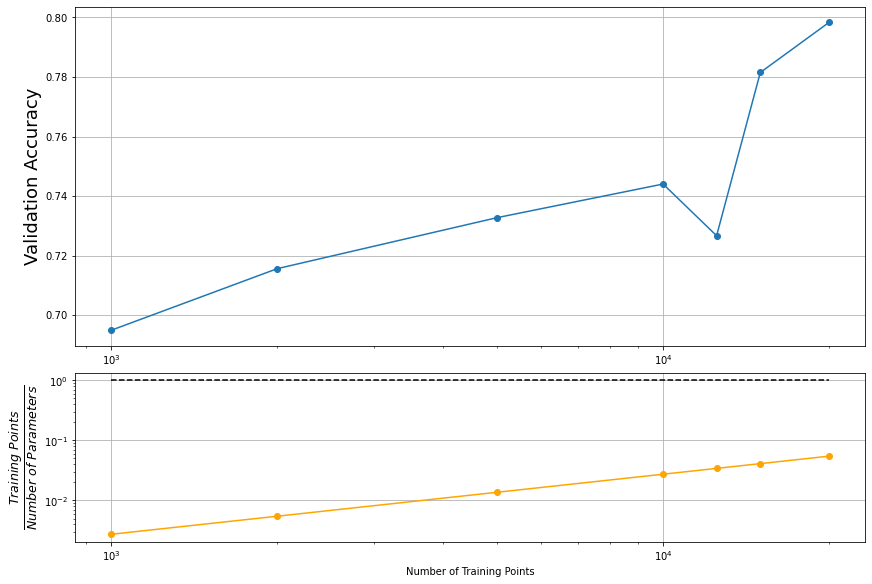

In [ ]:
#loss_ = [x[-1] for x in val_losses]
#acc_ = [x[-1] for x in val_accuracies]
acc_ = []
loss_ = []
for i in range(len(val_losses)):
    acc_idx = np.argmax(np.array(val_accuracies[i]))
    acc_.append(val_accuracies[i][acc_idx])
    loss_.append(val_losses[i][acc_idx])

trainable_params = np.sum([np.prod(v.get_shape()) for v in model.trainable_weights])
ratio = training_size / trainable_params


mosaic = """
    A
    A
    B
"""

fig = plt.figure(constrained_layout= True, figsize = (12,8))

ax_dict = fig.subplot_mosaic(mosaic)

ax_dict["A"].plot(training_size, acc_, "-o")
ax_dict["A"].set_xscale("log");
ax_dict["A"].set_ylabel("Validation Accuracy", size = 18);
ax_dict["A"].grid()

ax_dict["B"].plot(training_size, ratio, "-o", color = "orange")
ax_dict["B"].set_xscale("log");
ax_dict["B"].set_yscale("log");
ax_dict["B"].hlines(1, training_size[0], training_size[-1], linestyles = "dashed", color = "k")
ax_dict["B"].grid()
ax_dict["B"].set_ylabel(r"$\frac{Training\ Points}{Number\ of\ Parameters}$", size = 18);

plt.xlabel("Number of Training Points");


In [63]:
import shap
from shap import Explanation

In [50]:
df_train = pd.DataFrame(data = x_train, columns = train_keys)
df_val = pd.DataFrame(data = x_val, columns = train_keys)

In [ ]:
x_train_df = pd.DataFrame(x_train, columns = train_keys)
x_val_df = pd.DataFrame(x_val, columns = train_keys)

In [54]:
f = lambda x: model.predict(x)
#med = np.median(x, axis = 0).reshape((1,x_train.shape[1]))

explainer = shap.Explainer(f, df)
#explainer = shap.explainers.Permutation(f, df)

shap_values = explainer(df_val[:1000])

Permutation explainer: 1001it [1:12:24,  4.35s/it]                          


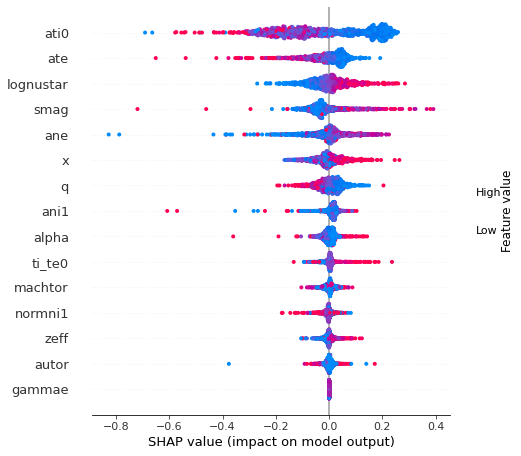

In [55]:
shap.plots.beeswarm(shap_values, max_display = 20)

In [69]:
shap.plots.waterfall(shap_values, max_display=20)

Exception: waterfall_plot requires a scalar base_values of the model output as the first parameter, but you have passed an array as the first parameter! Try shap.waterfall_plot(explainer.base_values[0], values[0], X[0]) or for multi-output models try shap.waterfall_plot(explainer.base_values[0], values[0][0], X[0]).

In [68]:
shap_values[0]

.values =
array([ 1.12395370e-02,  6.42691167e-02,  5.27819832e-03,  3.25836086e-03,
        1.61726223e-02, -5.90397120e-04,  3.72529056e-11,  5.40620706e-02,
       -3.81295320e-02,  1.57764612e-02,  1.76101623e-02,  1.85646143e-01,
       -2.58921091e-03,  3.48726942e-03, -5.03727866e-02])

.base_values =
array([0.71480557])

.data =
array([-3.31189206e-02, -3.21823551e-01, -2.21116535e-01, -5.67875277e-01,
       -7.44960860e-01, -2.22011916e-01, -2.27728735e-04, -9.01294808e-01,
       -4.08028458e-01, -3.75115312e-01, -1.39294802e-01, -8.99836469e-02,
       -1.22795960e-01, -8.65711560e-02, -1.30170249e+00])

In [ ]:
train_keys